# 加法进位实验


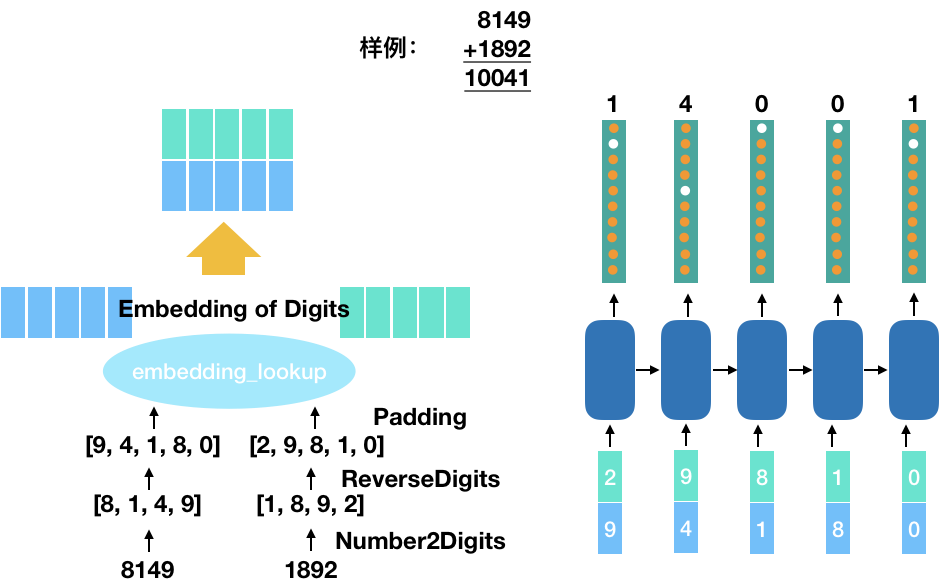

In [1]:
import numpy as np
import tensorflow as tf
import collections
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, optimizers, datasets
import os,sys,tqdm


## 数据生成
我们随机在 `start->end`之间采样除整数对`(num1, num2)`，计算结果`num1+num2`作为监督信号。

* 首先将数字转换成数字位列表 `convertNum2Digits`
* 将数字位列表反向
* 将数字位列表填充到同样的长度 `pad2len`


In [2]:
def gen_data_batch(batch_size, start, end):
    '''在(start, end)区间采样生成一个batch的整型的数据
    Args :
        batch_size: batch_size
        start: 开始数值
        end: 结束数值
    '''
    numbers_1 = np.random.randint(start, end, batch_size)
    numbers_2 = np.random.randint(start, end, batch_size)
    results = numbers_1 + numbers_2
    return numbers_1, numbers_2, results

def convertNum2Digits(Num):
    '''将一个整数转换成一个数字位的列表,例如 133412 ==> [1, 3, 3, 4, 1, 2]
    '''
    strNum = str(Num)
    chNums = list(strNum)
    digitNums = [int(o) for o in strNum]
    return digitNums

def convertDigits2Num(Digits):
    '''将数字位列表反向， 例如 [1, 3, 3, 4, 1, 2] ==> [2, 1, 4, 3, 3, 1]
    '''
    digitStrs = [str(o) for o in Digits]
    numStr = ''.join(digitStrs)
    Num = int(numStr)
    return Num

def pad2len(lst, length, pad=0):
    '''将一个列表用`pad`填充到`length`的长度 例如 pad2len([1, 3, 2, 3], 6, pad=0) ==> [1, 3, 2, 3, 0, 0]
    '''
    lst+=[pad]*(length - len(lst))
    return lst

def results_converter(res_lst):
    '''将预测好的数字位列表批量转换成为原始整数
    Args:
        res_lst: shape(b_sz, len(digits))
    '''
    res = [reversed(digits) for digits in res_lst]
    return [convertDigits2Num(digits) for digits in res]

def prepare_batch(Nums1, Nums2, results, maxlen):
    '''准备一个batch的数据，将数值转换成反转的数位列表并且填充到固定长度
    Args:
        Nums1: shape(batch_size,)
        Nums2: shape(batch_size,)
        results: shape(batch_size,)
        maxlen:  type(int)
    Returns:
        Nums1: shape(batch_size, maxlen)
        Nums2: shape(batch_size, maxlen)
        results: shape(batch_size, maxlen)
    '''
    Nums1 = [convertNum2Digits(o) for o in Nums1]
    Nums2 = [convertNum2Digits(o) for o in Nums2]
    results = [convertNum2Digits(o) for o in results]
    
    Nums1 = [list(reversed(o)) for o in Nums1]
    Nums2 = [list(reversed(o)) for o in Nums2]
    results = [list(reversed(o)) for o in results]
    
    Nums1 = [pad2len(o, maxlen) for o in Nums1]
    Nums2 = [pad2len(o, maxlen) for o in Nums2]
    results = [pad2len(o, maxlen) for o in results]
    
    return Nums1, Nums2, results

# 建模过程， 按照图示完成建模

In [3]:
class myRNNModel(keras.Model):
    def __init__(self):
        super(myRNNModel, self).__init__()
        self.embed_layer = tf.keras.layers.Embedding(10, 32, 
                                                    batch_input_shape=[None, None])
        
        self.rnncell = tf.keras.layers.SimpleRNNCell(64)
        self.rnn_layer = tf.keras.layers.RNN(self.rnncell, return_sequences=True)
        self.dense = tf.keras.layers.Dense(10)
        
    @tf.function
    def call(self, num1, num2):
        '''
        此处完成上述图中模型
        '''
        num1_emb = self.embed_layer(num1)
        num2_emb = self.embed_layer(num2)
        emb = tf.concat([num1_emb, num2_emb], axis=-1)
        rnn_out = self.rnn_layer(emb)
        logits = self.dense(rnn_out)
        return logits

In [4]:
@tf.function
def compute_loss(logits, labels):
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=labels)
    return tf.reduce_mean(losses)

@tf.function
def train_one_step(model, optimizer, x, y, label):
    with tf.GradientTape() as tape:
        logits = model(x, y)
        loss = compute_loss(logits, label)

    # compute gradient
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def train(steps, model, optimizer):
    loss = 0.0
    accuracy = 0.0
    for step in range(steps):
        datas = gen_data_batch(batch_size=200, start=0, end=555555555)
        Nums1, Nums2, results = prepare_batch(*datas, maxlen=11)
        loss = train_one_step(model, optimizer, tf.constant(Nums1, dtype=tf.int32), 
                              tf.constant(Nums2, dtype=tf.int32),
                              tf.constant(results, dtype=tf.int32))
        if step%50 == 0:
            print('step', step, ': loss', loss.numpy())

    return loss

def evaluate(model):
    datas = gen_data_batch(batch_size=2000, start=555555555, end=999999999)
    Nums1, Nums2, results = prepare_batch(*datas, maxlen=11)
    logits = model(tf.constant(Nums1, dtype=tf.int32), tf.constant(Nums2, dtype=tf.int32))
    logits = logits.numpy()
    pred = np.argmax(logits, axis=-1)
    res = results_converter(pred)
    for o in list(zip(datas[2], res))[:20]:
        print(o[0], o[1], o[0]==o[1])

    print('accuracy is: %g' % np.mean([o[0]==o[1] for o in zip(datas[2], res)]))


In [5]:
optimizer = optimizers.Adam(0.001)
model = myRNNModel()

In [6]:
train(3000, model, optimizer)
evaluate(model)

step 0 : loss 2.3233862
step 50 : loss 1.9335713
step 100 : loss 1.9014964
step 150 : loss 1.9029953
step 200 : loss 1.890281
step 250 : loss 1.8847324
step 300 : loss 1.8811177
step 350 : loss 1.8810973
step 400 : loss 1.887206
step 450 : loss 1.8830051
step 500 : loss 1.8696395
step 550 : loss 1.8889906
step 600 : loss 1.8814337
step 650 : loss 1.8775617
step 700 : loss 1.8855375
step 750 : loss 1.8884947
step 800 : loss 1.8863083
step 850 : loss 1.88235
step 900 : loss 1.8741837
step 950 : loss 1.8749866
step 1000 : loss 1.8746682
step 1050 : loss 1.8810929
step 1100 : loss 1.8729712
step 1150 : loss 1.8728445
step 1200 : loss 1.8802013
step 1250 : loss 1.8608494
step 1300 : loss 1.8595172
step 1350 : loss 1.8412383
step 1400 : loss 1.8150235
step 1450 : loss 1.7454337
step 1500 : loss 1.6317149
step 1550 : loss 1.5430403
step 1600 : loss 1.3952606
step 1650 : loss 1.1996406
step 1700 : loss 1.0313581
step 1750 : loss 0.8839886
step 1800 : loss 0.77822775
step 1850 : loss 0.70142716